In [ ]:
import numpy as np 
import pandas as pd 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Race Estimation

In [37]:
DATA_DIR = "C:/Users/N9519661/Desktop/UTKFace"
Train_Test_Split = 0.7
IM_WIDTH = IM_HEIGHT = 198

#Gender : O as Male and 1 as Female
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())

# Classification of Gender
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [ ]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [39]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [40]:
attributes = list(map(parse_filepath, files))

C:/Users/N9519661/Desktop/UTKFace\39_1_20170116174525125.jpg.chip.jpg
C:/Users/N9519661/Desktop/UTKFace\61_1_20170109142408075.jpg.chip.jpg
C:/Users/N9519661/Desktop/UTKFace\61_1_20170109150557335.jpg.chip.jpg


In [41]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['Age', 'Gender', 'Race', 'File Name']
df = df.dropna()
df.head()

,age,gender,race,file
0,100.0,male,white,C:/Users/N9519661/Desktop/UTKFace\100_0_0_2017...
1,100.0,male,white,C:/Users/N9519661/Desktop/UTKFace\100_0_0_2017...
2,100.0,female,white,C:/Users/N9519661/Desktop/UTKFace\100_1_0_2017...
3,100.0,female,white,C:/Users/N9519661/Desktop/UTKFace\100_1_0_2017...
4,100.0,female,white,C:/Users/N9519661/Desktop/UTKFace\100_1_0_2017...


# Exploratory Data Analysis

In [42]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


# Data preparation for the Training

In [49]:
p = np.random.permutation(len(df))

train_up_to = int(len(df) * Train_Test_Split)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split training index into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [50]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

# Training the Model to Determing the Gender and Race

In [51]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    x = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = conv_block(input_layer, filters=32, bn=False, pool=False)
x = conv_block(x, filters=32*2)
x = conv_block(x, filters=32*3)
x = conv_block(x, filters=32*4)
x = conv_block(x, filters=32*5)
x = conv_block(x, filters=32*6)
bottleneck = GlobalMaxPool2D()(x)

# for age calculation
x = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)

# for race prediction
x = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(x)

# for gender prediction
x = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})


In [54]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,steps_per_epoch=len(train_idx)//batch_size,epochs=1,callbacks=callbacks,alidation_data=valid_gen,validation_steps=len(valid_idx)//valid_batch_size)
                    


Epoch 1/1
141/141 [==============================] - 1416s 10s/step - loss: 2.0448 - age_output_loss: 0.0466 - race_output_loss: 1.0370 - gender_output_loss: 0.3961 - age_output_mae: 0.1733 - race_output_accuracy: 0.6136 - gender_output_accuracy: 0.8238 - val_loss: 2.8776 - val_age_output_loss: 0.0380 - val_race_output_loss: 1.3679 - val_gender_output_loss: 0.7858 - val_age_output_mae: 0.1606 - val_race_output_accuracy: 0.4414 - val_gender_output_accuracy: 0.5750


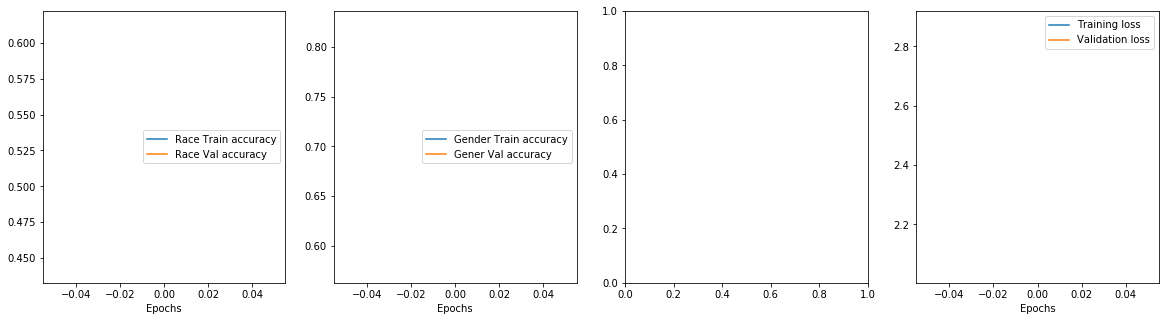

In [61]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

  
    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [73]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 196, 196, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 194, 194, 64) 18496       conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 194, 194, 64) 256         conv2d_20[0][0]                  
____________________________________________________________________________________________